In [1]:
import os

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

import torchvision
import torchvision.transforms as tf

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
import pyro.contrib.easybnn as ezbnn

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
pyro.enable_validation(True)
pyro.set_rng_seed(42)

In [3]:
class Chunk(nn.Module):
    
    def __init__(self, num_chunks, dim=-1):
        super().__init__()
        self.num_chunks = num_chunks
        self.dim= dim
        
    def forward(self, x):
        return x.chunk(self.num_chunks, self.dim)

In [4]:
class VAE:
    
    def __init__(self, z_dim, encoder, decoder, dataset_size):
        super().__init__()
        self.z_dim = z_dim
        self.encoder = encoder
        self.decoder = decoder
        self.dataset_size = dataset_size
        
    def model(self, x, *args, **kwargs):
        with pyro.plate("data", subsample=x, size=self.dataset_size):
            loc = x.new_zeros(x.size(0), self.z_dim)
            scale = x.new_ones(x.size(0), self.z_dim)
            z = pyro.sample("z", dist.Normal(loc, scale).to_event(1))
            logits = self.decoder(z)
            pyro.sample("obs", dist.Bernoulli(logits=logits).to_event(1), obs=x)
        
    def guide(self, x, *args, **kwargs):
        loc, _scale = self.encoder(x)
        with pyro.plate("data", subsample=x, size=self.dataset_size):
            pyro.sample("z", dist.Normal(loc, F.softplus(_scale)).to_event(1))
            
    def sample(self, num_samples):
        with pyro.plate("data"):
            loc = torch.zeros(num_samples, self.z_dim)
            scale = torch.ones(num_samples, self.z_dim)
            z = pyro.sample("z", dist.Normal(loc, scale).to_event(1))
            logits = self.decoder(z)
            return pyro.sample("decoder.observation_model.obs", dist.Bernoulli(logits=logits).to_event(1))

In [5]:
flatten_tf = tf.Lambda(lambda x: x.flatten())
binarize_tf = tf.Lambda(lambda x: x.gt(0.5).float())
transform = tf.Compose([tf.ToTensor(), flatten_tf, binarize_tf])

In [6]:
root = os.environ.get("DATASETS_PATH", "./data")

In [7]:
train_dataset = torchvision.datasets.FashionMNIST(root=root, download=True, transform=transform)
train_loader = data.DataLoader(train_dataset, batch_size=100, shuffle=True)

In [8]:
mnist_test = torchvision.datasets.MNIST(root=root, transform=transform, train=False)
mnist_test_loader = data.DataLoader(mnist_test, batch_size=250)

In [10]:
fmnist_test = torchvision.datasets.FashionMNIST(root=root, download=True, transform=transform, train=False)
fmnist_test_loader = data.DataLoader(fmnist_test, batch_size=250)

In [12]:
encoder = ezbnn.util.to_pyro_module(
    nn.Sequential(nn.Linear(784, 200), nn.ReLU(), nn.Linear(200, 60), Chunk(2)), name="encoder")
decoder = ezbnn.util.to_pyro_module(
    nn.Sequential(nn.Linear(30, 200), nn.ReLU(), nn.Linear(200, 784)), name="decoder")
vae = VAE(30, encoder, decoder, len(train_dataset))

In [13]:
optim = pyro.optim.Adam({"lr": 1e-3})

In [14]:
svi = pyro.infer.SVI(vae.model, vae.guide, optim, loss=pyro.infer.TraceMeanField_ELBO())

In [15]:
pyro.clear_param_store()
elbos = []
for _ in tqdm(range(25)):
    for x, _ in iter(train_loader):
        elbos.append(svi.step(x))

In [29]:
def moving_average(values, window_size):
    t = torch.tensor(values).unsqueeze(0).unsqueeze(0)
    w = torch.ones(1, 1, window_size) / window_size
    return F.conv1d(t, w).squeeze()

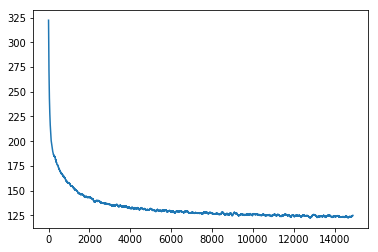

In [31]:
plt.plot(moving_average(list(map(lambda e: e / len(train_dataset), elbos)), 100))

In [42]:
def per_data_logprob(tr, site):
    msg = tr.nodes[site]
    base_dist = msg["fn"].base_dist
    value = msg["value"]
    return base_dist.log_prob(value).sum(1).detach()

In [47]:
def per_data_importance_elbos(vae_obj, data_loader, num_importance_samples):
    ies = []
    log_num_samples = torch.tensor(num_importance_samples * 1.).log()
    for x, _ in tqdm(iter(data_loader)):
        iw = []
        for _ in range(num_importance_samples):
            guide_tr = poutine.trace(vae_obj.guide).get_trace(x)
            guide_log_probs = per_data_logprob(guide_tr, "z")
            model_tr = poutine.trace(poutine.replay(vae_obj.model, guide_tr)).get_trace(x)
            model_log_probs = per_data_logprob(model_tr, "z") + per_data_logprob(
                model_tr, "decoder.observation_model.obs")
            iw.append(model_log_probs - guide_log_probs)
        log_weights = torch.stack(iw)
        ies.append(torch.logsumexp(log_weights - log_num_samples, 0))
    return torch.cat(ies)

In [18]:
mnist_ies = per_data_importance_elbos(vae, mnist_test_loader, 100)

In [19]:
fmnist_ies = per_data_importance_elbos(vae, fmnist_test_loader, 100)

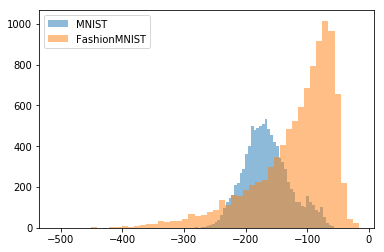

In [26]:
plt.hist(mnist_ies, bins=50, label="MNIST", alpha=0.5);
plt.hist(fmnist_ies, bins=50, label="FashionMNIST", alpha=0.5)
plt.legend();

In [27]:
def plot(samples):
    f, ax = plt.subplots(samples.size(0), samples.size(1), figsize=(9, 9))
    for i, axr in enumerate(ax):
        for j, ax in enumerate(axr):
            ax.imshow(samples[i, j], cmap="gray")
            ax.axis("off")

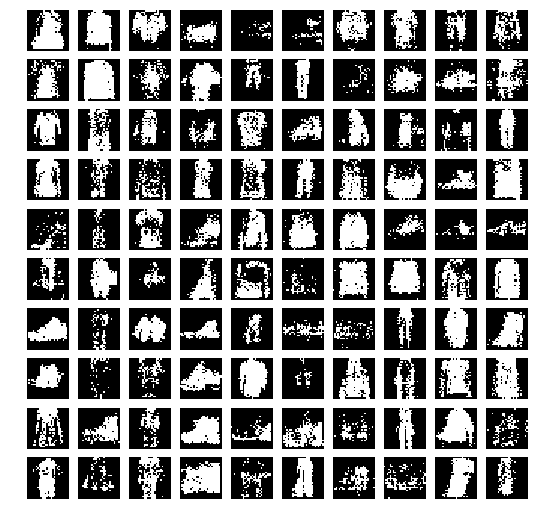

In [28]:
samples = vae.sample(100).reshape(10, 10, 28, 28)
plot(samples)

In [32]:
class BayesianVAE:
    
    def __init__(self, z_dim, encoder, decoder, dataset_size):
        super().__init__()
        self.z_dim = z_dim
        self.encoder = encoder
        self.decoder = decoder
        self.dataset_size = dataset_size
        
    def model(self, x, *args, **kwargs):
        with pyro.plate("data", subsample=x, size=self.dataset_size):
            loc = x.new_zeros(x.size(0), self.z_dim)
            scale = x.new_ones(x.size(0), self.z_dim)
            z = pyro.sample("z", dist.Normal(loc, scale).to_event(1))
        self.decoder.model(z, x)
        
    def guide(self, x, *args, **kwargs):
        loc, _scale = self.encoder(x)
        with pyro.plate("data", subsample=x, size=self.dataset_size):
            z = pyro.sample("z", dist.Normal(loc, F.softplus(_scale)).to_event(1))
        self.decoder.guide(z, x)
        
    def sample(self, num_samples, num_decoder_samples=10, aggregate=False):
        with pyro.plate("data"):
            loc = x.new_zeros(num_samples, self.z_dim)
            scale = x.new_ones(num_samples, self.z_dim)
            z = pyro.sample("z", dist.Normal(loc, scale).to_event(1))
        return self.decoder.predict(z, num_decoder_samples, aggregate=aggregate)

In [34]:
bayesian_encoder = ezbnn.util.to_pyro_module(
    nn.Sequential(nn.Linear(784, 200), nn.ReLU(), nn.Linear(200, 60), Chunk(2)), name="bayesian_encoder")

net = nn.Sequential(nn.Linear(30, 200), nn.ReLU(), nn.Linear(200, 784))
prior = ezbnn.priors.IIDPrior(dist.Normal(0, 1.))
guide = ezbnn.guides.ParameterwiseDiagonalNormal
model = ezbnn.observation_models.Bernoulli(len(train_dataset), event_dim=1)

bayesian_decoder = ezbnn.bnn.SupervisedBNN(net, prior, model, guide, name="decoder")

bayesian_vae = BayesianVAE(30, bayesian_encoder, bayesian_decoder, len(train_dataset))

In [35]:
optim = pyro.optim.Adam({"lr": 1e-3})
bayesian_svi = pyro.infer.SVI(bayesian_vae.model, bayesian_vae.guide, optim, loss=pyro.infer.TraceMeanField_ELBO())

In [36]:
pyro.clear_param_store()
b_elbos = []
for _ in tqdm(range(25)):
    for x, _ in iter(train_loader):
        with ezbnn.poutine.local_reparameterization():
            b_elbos.append(bayesian_svi.step(x.gt(0.5).float()))

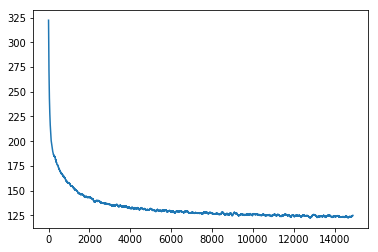

In [38]:
plt.plot(moving_average(list(map(lambda e: e / len(train_dataset), elbos)), 100))

In [39]:
bvae_samples = bayesian_vae.sample(100, 10, aggregate=True).sigmoid().view(10, 10, 28, 28)

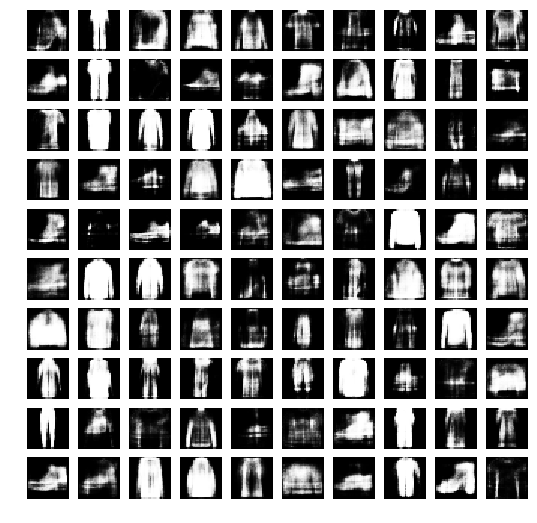

In [40]:
plot(bvae_samples)

In [50]:
with ezbnn.poutine.local_reparameterization():
    bfmnist_ies = per_data_importance_elbos(bayesian_vae, fmnist_test_loader, 100)
    bmnist_ies = per_data_importance_elbos(bayesian_vae, mnist_test_loader, 100)

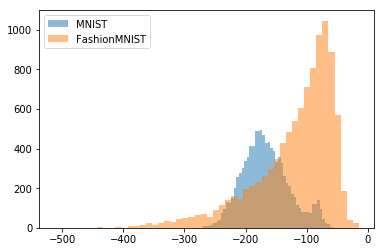

In [51]:
plt.hist(bmnist_ies, bins=50, alpha=0.5, label="MNIST")
plt.hist(bfmnist_ies, bins=50, alpha=0.5, label="FashionMNIST")
plt.legend();